# Automatic data downloading

In this example we will show how one can download data from a Jupyter notebook.

The [PhysOcean](https://github.com/gher-uliege/PhysOcean.jl) module provides ways to automatically download data from 
- the [World Ocean Database](https://www.nodc.noaa.gov/OC5/WOD/pr_wod.html) and
- the [CMEMS](http://marine.copernicus.eu/) In-Situ TAC.

This module can be installed by: 

```julia
using Pkg
Pkg.add("PhysOcean")

```
or in the package REPL
```julia
(@v1.11) pkg> add PhysOcean
```
We make sure that the latest version is installed.

In [1]:
using Pkg
Pkg.activate("../..")
Pkg.instantiate()
Pkg.add(PackageSpec(name="PhysOcean", rev="master"))

  Activating project at `~/Projects/Diva-Workshops`
    Updating git-repo `https://github.com/gher-uliege/PhysOcean.jl.git`
   Resolving package versions...
  No Changes to `~/Projects/Diva-Workshops/Project.toml`
  No Changes to `~/Projects/Diva-Workshops/Manifest.toml`


In [2]:
using Makie, CairoMakie, GeoMakie
using PhysOcean           
using DIVAnd               
using Dates
using Statistics
include("../config.jl")

"https://dox.uliege.be/index.php/s/qJtEotmkCZVqcx8/download"

## Settings
Define the time and geospatial bounding box for downloading the data

In [3]:
# resolution (the resolution is only used for DIVAnd analyses)
dx = dy = 0.25   # medium size test 

# vectors defining the longitude and latitudes grids
# Here longitude and latitude correspond to the Mediterranean Sea
lonr = -7:dx:37
latr = 30:dy:46

# time range of the in-situ data
timerange = [Date(2016, 1, 1), Date(2016, 12, 31)]

2-element Vector{Date}:
 2016-01-01
 2016-12-31

In [4]:
# Name of the variable
varname = "Salinity"

"Salinity"

<div class="alert alert-block alert-warning">
⚠️ Please use your own email address (!)<br>
It is only use to get notified by mail once the dataset is ready.
</div>

In [5]:
if isfile("email.txt")
    email = strip(read("email.txt", String))
    @info("Getting email address from email.txt")
else
    @warn("Create a file 'email.txt' if you want to query data to the World Ocean Database")
end

┌ Warning: Create a file 'email.txt' if you want to query data to the World Ocean Database
└ @ Main In[5]:5


## Download the data

An example for bulk access data from the World Ocean Database (WOD), simulating a web-user.    
Here you have to possibilities:
1. Execute the next cell to query data from the WOD. It can take several tens of minutes.
2. Use an archive already extracted from the WOD, so there is no need to wait <br>
(cell starting with `download_check(...)`).

Next define the directory where the results will be saved. This directory must exist and must be empty.   
The command `mkpath` will create this path (including parent path).

In [6]:
basedir = joinpath(datadir, "WOD-temporary-dir")
isdir(basedir) ? rm(basedir, recursive=true) : mkpath(basedir)
WorldOceanDatabase.download(lonr, latr, timerange, varname, email, basedir);

LoadError: UndefVarError: `email` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

__2nd possibility:__ download and extract archive containing a sample of WOD data.

In [7]:
download_check(WODdatafile, WODdatafileURL)
extractcommand = `tar -C $(datadir) -xzf $(WODdatafile)`
run(extractcommand);

[ Info: File already downloaded


## Load data
Load the data into memory and perform, if needed, an additional subsetting

In [8]:
# load all data under basedir as a double-precision floating point variable
obsval, obslon, obslat, obsdepth, obstime, obsid =
    WorldOceanDatabase.load(Float64, basedir, "Salinity");
@info("Number of data points: $(length(obsval))")

[ Info: Loading files from ../data/WOD-temporary-dir/CTD/ocldb1560238968.6282.CTD.nc
[ Info: Loading files from ../data/WOD-temporary-dir/GLD/ocldb1560238968.6282.GLD.nc
[ Info: Loading files from ../data/WOD-temporary-dir/PFL/ocldb1560238968.6282.PFL.nc
[ Info: Number of data points: 4509789


Check some observation IDs

In [9]:
@show obsid[1], obsid[2];

(obsid[1], obsid[2]) = ("wod_018097040O", "wod_018097040O")


With `checkobs` we get an overview of the extremal values of each dimension and variable.

In [10]:
checkobs((obslon, obslat, obsdepth, obstime), obsval, obsid)

[ Info: Checking ranges for dimensions and observations


              minimum and maximum of obs. dimension 1: (-6.994999885559082, 36.989349365234375)
              minimum and maximum of obs. dimension 2: (31.152000427246094, 45.95199966430664)
              minimum and maximum of obs. dimension 3: (-0.0, 3919.363525390625)
              minimum and maximum of obs. dimension 4: (DateTime("2016-01-01T00:00:00"), DateTime("2016-12-31T23:54:21.959"))
                          minimum and maximum of data: (10.0, 39.98847198486328)


## Additional sub-setting 
Based on time and depth for plotting.     
For instance the month can be extracted from the `Date` using `Dates.month.(obstime)`.

In [11]:
# depth range levels
depthr = [0.0, 20.0]

# month range (January to March)
timer = [1, 3]

# additional sub-setting and discard wrong negative salinities
sel = (
    (obsval .> 0) .&
    (minimum(depthr) .<= obsdepth .<= maximum(depthr)) .&
    (minimum(timer) .<= Dates.month.(obstime) .<= maximum(timer))
);

@show typeof(sel);
@show size(sel);

typeof(sel) = BitVector
size(sel) = (4509789,)


The new variables (ending by `sel`) are a sub-selection based on the previous criteria.

In [12]:
valsel = obsval[sel]
lonsel = obslon[sel]
latsel = obslat[sel]
depthsel = obsdepth[sel]
timesel = obstime[sel]
idssel = obsid[sel];

Let's perform again the check.

In [13]:
checkobs((lonsel, latsel, depthsel, timesel), valsel, idssel)

              minimum and maximum of obs. dimension 1: (-6.86899995803833, 36.989349365234375)
              minimum and maximum of obs. dimension 2: (31.738000869750977, 45.922000885009766)
              minimum and maximum of obs. dimension 3: (-0.0, 19.999536514282227)
              minimum and maximum of obs. dimension 4: (DateTime("2016-01-01T00:00:00"), DateTime("2016-03-31T23:54:21.959"))
                          minimum and maximum of data: (17.783000946044922, 39.38759994506836)


[ Info: Checking ranges for dimensions and observations


Number of selected data points

In [14]:
length(valsel)

42312

## Bathymetry download 
For plotting purpose. See [2-01-topography](2-01-topography.ipynb) for details.

In [15]:
bathname = gebco16file
download_check(gebco16file, gebco16fileURL)
bathisglobal = true

# Extract the bathymetry for plotting
bx, by, b = DIVAnd.extract_bath(bathname, bathisglobal, lonr, latr);

[ Info: File already downloaded


Create a simple plot to show the domain.

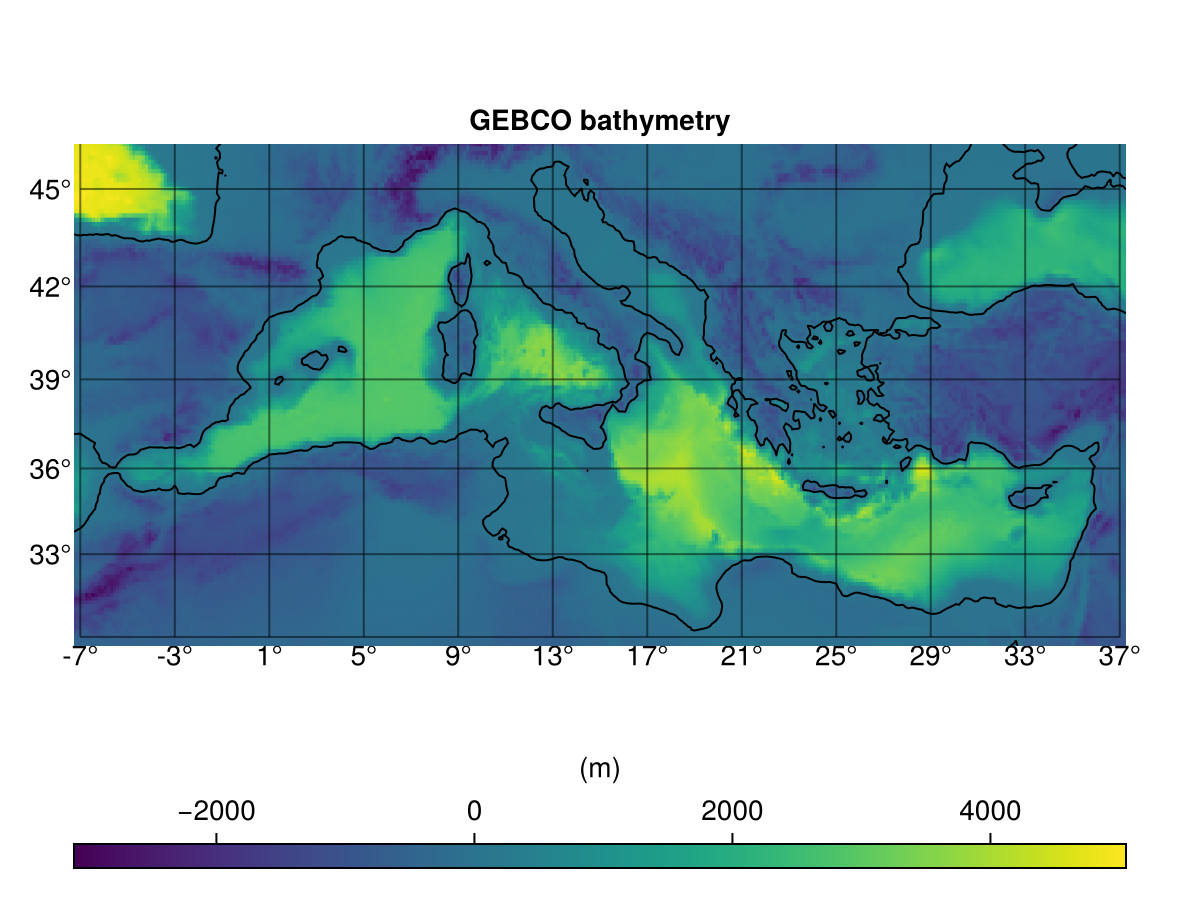

In [16]:
plot_bathy(bx, by, b, xticks = -7.0:4.0:37, yticks = 30.0:3.0:48.0)

## Data plotting
The bathymetry is used to display a land-sea mask using the `contourf` function with 2 levels.      
The data are shown as colored circles using `scatter`.

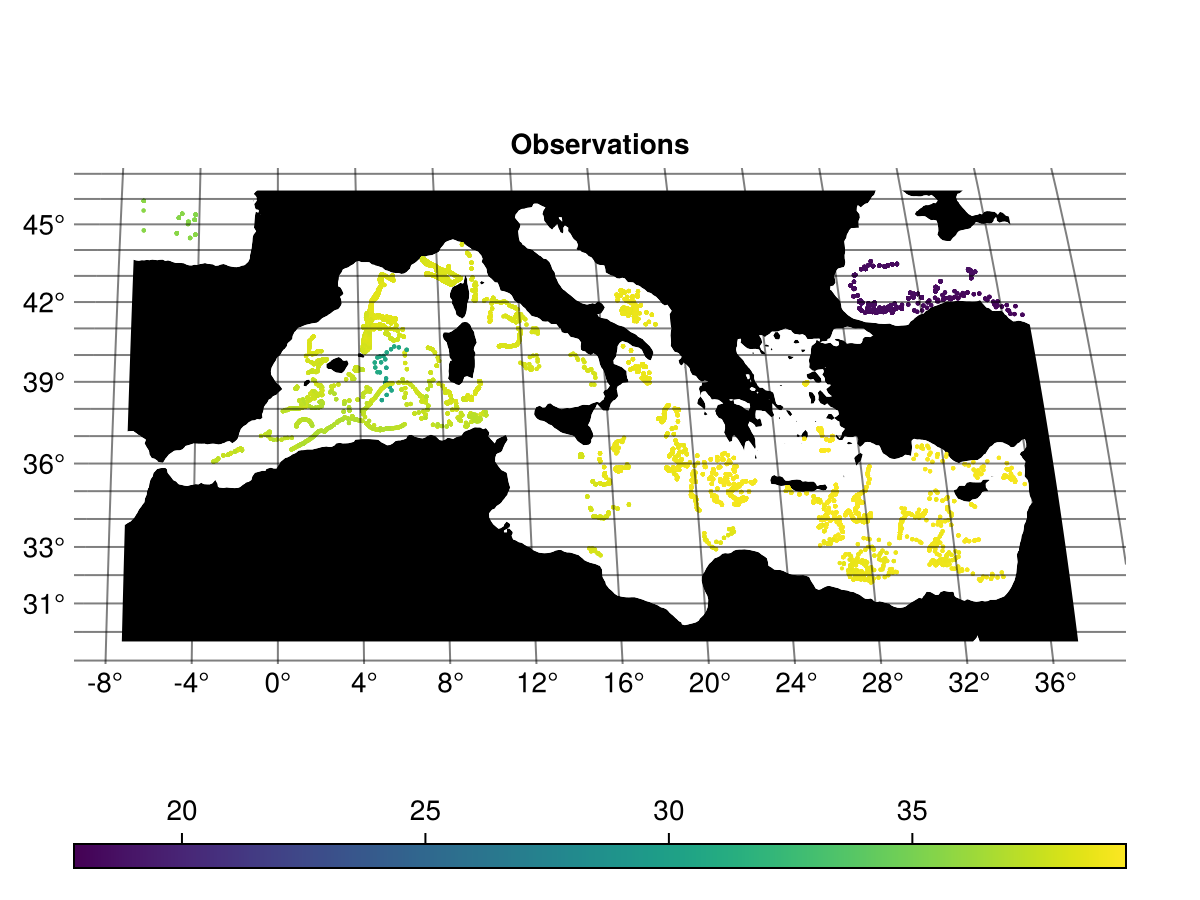

In [17]:
f = Figure()
ax = GeoAxis(f[1, 1], title = "Observations")
contourf!(ax, bx, by, b, levels = [-1e5, 0, 1e5], colormap = Reverse("binary"))
sc = scatter!(ax, obslon[sel], obslat[sel]; color = obsval[sel], markersize = 3)
Colorbar(f[2, 1], sc, vertical = false)
f

# Check for duplicates

There are two ways to call the function `checkduplicates`:

In [18]:
?DIVAnd.Quadtrees.checkduplicates

!!! warning
    The following bindings may be internal; they may change or be removed in future versions:

      * `DIVAnd.Quadtrees`


```
dupl = checkduplicates(x,value,delta,deltavalue)
```

Based on the coordinates `x` (a tuple of longitudes `lons`, latitudes `lats`, depths (`zs`) and times (`times` vector of `DateTime`)), search for points which are in the same spatio-temporal bounding  box of length `delta`. `delta` is a vector with 4 elements corresponding to longitude, latitude, depth and time (in days). `dupl` a vector of vectors containing the indices of the duplicates.

!!! note
    Observations and coordinates should not be NaN or Inf.


---

```
dupl = checkduplicates(x1,value1,x2,v2,value2,delta,deltavalue)
```

Report duplicates of observations in data set (x2,v2) which are also in data set (x1,v1). `x1` and `x2` are tuples of vectors with the coordinates, `v1` and `v2` are the corresponding values.

!!! note
    Observations and coordinates should not be NaN or Inf.



We load a small ODV file containing data in the same domain to test the duplicate detection.     
We use the function `ODVspreadsheet.load` available within `DIVAnd.jl`.

In [19]:
download_check(smallODVsamplefile, smallODVsamplefileURL)

[ Info: File already downloaded


In [20]:
obsval_ODV, obslon_ODV, obslat_ODV, obsdepth_ODV, obstime_ODV, obsid_ODV =
    ODVspreadsheet.load(
        Float64,
        [smallODVfile],
        ["Water body salinity"];
        nametype = :localname,
    );

[ Info: Reading data from file ../data/small_ODV_sample.txt
[ Info: No. of profiles in the file: 71
[ Info: Working on variable Water body salinity
[ Info: Starting loop on the 71 profiles
[ Info: Done reading the profiles


In [21]:
length(obsval_ODV)

28264

In [22]:
checkobs((obslon_ODV, obslat_ODV, obsdepth_ODV, obstime_ODV), obsval_ODV, obsid_ODV)

              minimum and maximum of obs. dimension 1: (16.72791, 17.98836)
              minimum and maximum of obs. dimension 2: (35.216, 36.25)
              minimum and maximum of obs. dimension 3: (0.0, 4020.61646)
              minimum and maximum of obs. dimension 4: (DateTime("1966-02-13T05:00:00"), DateTime("2016-11-24T10:39:00"))
                          minimum and maximum of data: (37.1775, 39.313)


[ Info: Checking ranges for dimensions and observations


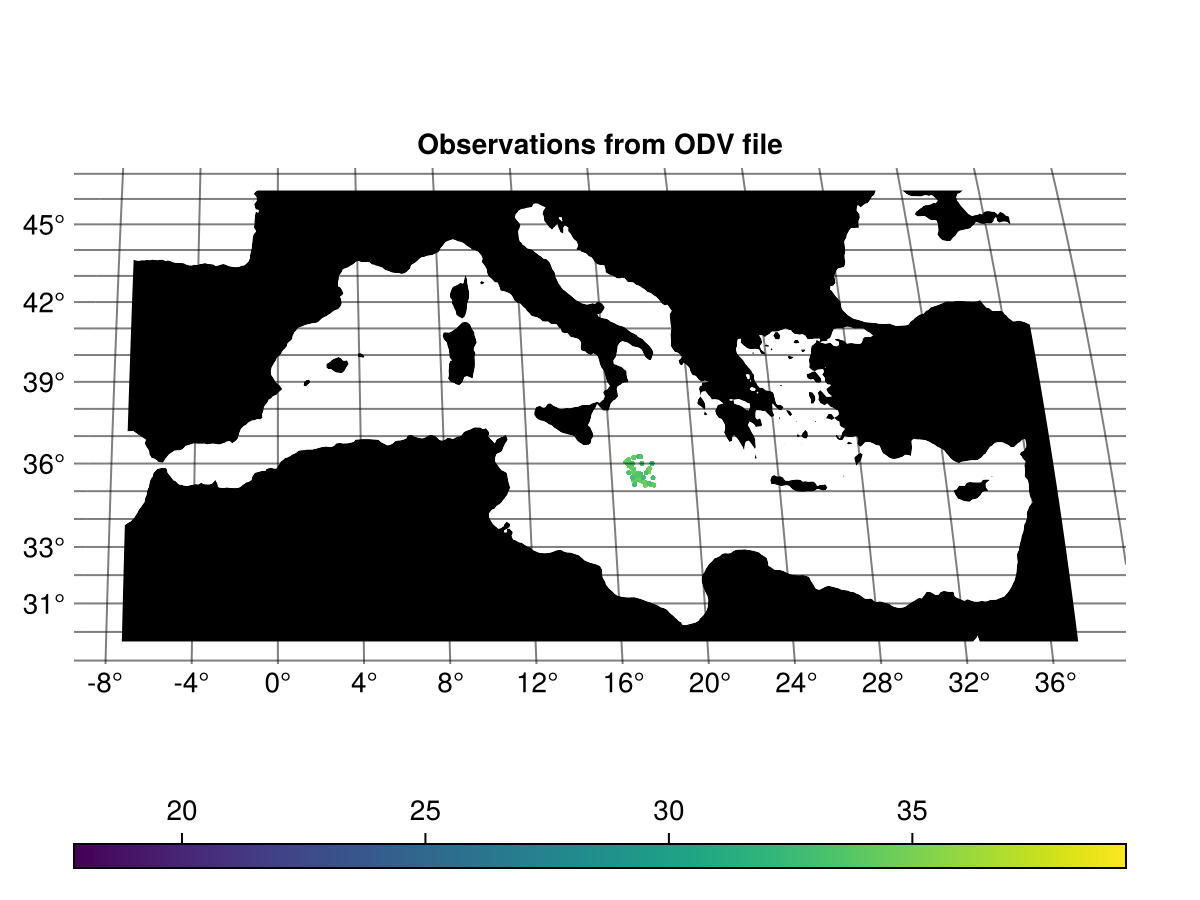

In [23]:
f = Figure()
ax = GeoAxis(f[1, 1], title = "Observations from ODV file")
contourf!(ax, bx, by, b, levels = [-1e5, 0, 1e5], colormap = Reverse("binary"))
scatter!(ax, obslon_ODV, obslat_ODV, color = obsval_ODV, markersize = 3)
Colorbar(f[2, 1], sc, vertical = false)
f

Look for duplicates
* within 0.01 degree (about 1km)
* within 0.01 m depth
* within 1 minute.      

Difference in value is 0.01 psu.

In [24]:
dupl = DIVAnd.Quadtrees.checkduplicates(
    (obslon_ODV, obslat_ODV, obsdepth_ODV, obstime_ODV),
    obsval_ODV,
    (obslon, obslat, obsdepth, obstime),
    obsval,
    (0.01, 0.01, 0.01, 1 / (24 * 60)),
    0.01,
);

In [25]:
size(obsval) == size(dupl)

true

* `dupl` is an array of the same length as `obsval`
* If the i-th element of `dupl` is an empty list, then the i-th element in `obsval` is probably not a duplicate
* Otherwise, the i-th element in `obsval` is probably a duplicate of the element `val_ODV` with the indices `dupl[i]`.

In [26]:
dupl[1]

Int64[]

To get a list of possible duplicates, we check for the elements of `dupl` that are not empty.

In [27]:
index = findall(.!isempty.(dupl))

5195-element Vector{Int64}:
 3195059
 3195060
 3195062
 3195063
 3195065
 3195066
 3195067
 3195069
 3195070
 3195071
 3195073
 3195074
 3195075
       ⋮
 4268649
 4268651
 4268652
 4268653
 4268654
 4268656
 4268657
 4268658
 4268660
 4268661
 4268662
 4268663

Number of duplicate candidates

In [28]:
length(index)

5195

Check the first reported duplicate

In [29]:
if length(index) > 0
    index_WOD = index[1]
else
    @info("No duplicate detected")
end

3195059

Show its coordinates and value from the ODV file:

In [30]:
obslon[index_WOD],
obslat[index_WOD],
obsdepth[index_WOD],
obstime[index_WOD],
obsval[index_WOD]

(17.885482788085938, 35.23445129394531, 2.4818837642669678, DateTime("2016-06-14T10:38:27.239"), 38.85300064086914)

They are quite close to the data point with the index:

In [31]:
dupl[index_WOD]

1-element Vector{Int64}:
 20508

In [32]:
index_ODV = dupl[index_WOD][1]

20508

In [33]:
obslon_ODV[index_ODV],
obslat_ODV[index_ODV],
obsdepth_ODV[index_ODV],
obstime_ODV[index_ODV],
obsval_ODV[index_ODV]

(17.88548, 35.23445, 2.48189, DateTime("2016-06-14T10:39:00"), 38.853)

Indeed, it is quite likely that they are duplicates.

Combine the dataset and retain only new points from WOD

In [34]:
newpoints = findall(isempty.(dupl));
@show length(newpoints)

length(newpoints) = 4504594


4504594

In [35]:
obslon_combined = [obslon_ODV; obslon[newpoints]];
obslat_combined = [obslat_ODV; obslat[newpoints]];
obsdepth_combined = [obsdepth_ODV; obsdepth[newpoints]];
obstime_combined = [obstime_ODV; obstime[newpoints]];
obsval_combined = [obsval_ODV; obsval[newpoints]];
obsids_combined = [obsid_ODV; obsid[newpoints]];

## CMEMS data download

<div class="alert alert-block alert-warning">
⚠️ A function <code>CMEMS.download</code> was implemented, but due to the change in CMEMS data access, it is not working anymore.
</div>